In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
torch.manual_seed(42)

In [4]:
train_path = "training.csv"
test_path = "test.csv"

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
from data_utils import FacialKeypointsDataset

BATCH_SIZE = 128

train_dataset = FacialKeypointsDataset(data_path=train_path, train=True)

In [6]:
from data_utils import mean_std

mean, std = mean_std(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False))

mean: tensor([54.7852]), std: tensor([25.8161])


In [7]:
train_dataset = FacialKeypointsDataset(data_path=train_path, transform=transforms.Normalize(mean=mean, std=std), train=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

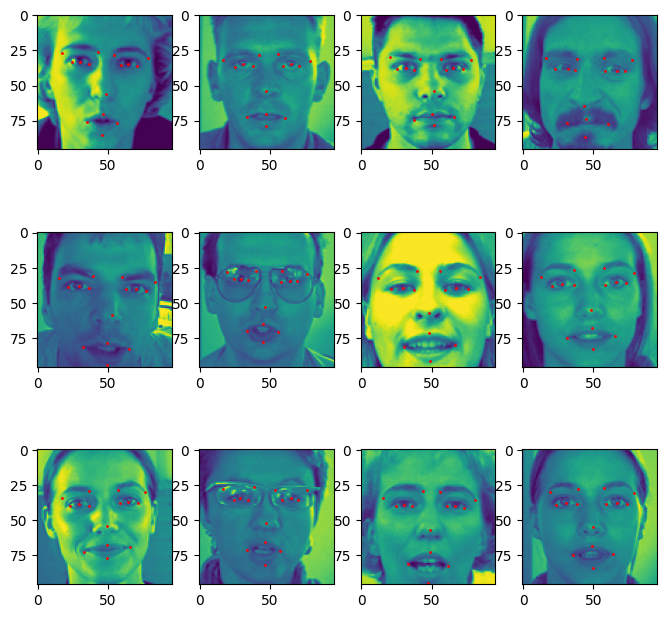

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img, keypoints = train_dataset[i]
    x = keypoints[0::2]
    y = keypoints[1::2]
    img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.scatter(x, y, c="red", s=1)
plt.show()

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# # Can be used to calculate output sizes after each layer
# def calc_size(input_size, kernel_size, padding, stride):
#     return (input_size + 2* padding - kernel_size + 1) / stride

# calc_size(96, 3, 0, 1)

Starting training loop for model 'TwoConvLayersModel'. Epochs: 10, batches: 56


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Finished training, last avg batch loss: 7.624155044555664
Starting training loop for model 'ThreeConvLayersModel'. Epochs: 10, batches: 56


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


Finished training, last avg batch loss: 6.038083553314209
Starting training loop for model 'TwoConvLayersWithDropoutsModel'. Epochs: 10, batches: 56


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Finished training, last avg batch loss: 9.715353012084961
Starting training loop for model 'ThreeConvLayersWithDropoutsModel'. Epochs: 10, batches: 56


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

Finished training, last avg batch loss: 12.056699752807617


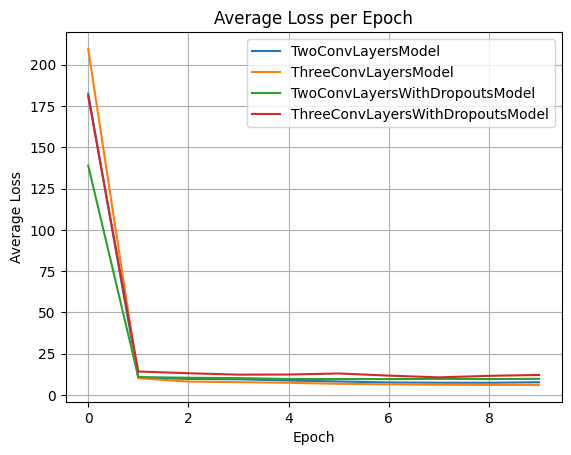

In [21]:
from models_comparator import ModelsComparator
import models

EPOCHS = 10
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.001

models_settings = []

model1 = models.TwoConvLayersModel()
models_settings.append([
    model1, 
    torch.optim.Adam(model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY), 
    nn.MSELoss()])

model2 = models.ThreeConvLayersModel()
models_settings.append([
    model2, 
    torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY), 
    nn.MSELoss()])

model3 = models.TwoConvLayersWithDropoutsModel()
models_settings.append([
    model3, 
    torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY), 
    nn.MSELoss()])

model4 = models.ThreeConvLayersWithDropoutsModel()
models_settings.append([
    model4, 
    torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY), 
    nn.MSELoss()])


comparator = ModelsComparator(models_settings, train_dataloader)
comparator.compare_models(EPOCHS, device)

comparator.plot_comparison_results()

In [12]:
import torchmetrics
from train_loop import train_loop
from models import TwoConvLayersModel

EPOCHS = 50
LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.001

model = TwoConvLayersModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss().to(device)

model1_results = train_loop(
    train_dataloader,
    model,
    optimizer,
    criterion,
    epochs=EPOCHS,
    device=device
)

Starting training loop for model 'TwoConvLayersModel'. Epochs: 50, batches: 56


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]

Finished training, last avg batch loss: 5.268289566040039


In [13]:
test_dataset = FacialKeypointsDataset(data_path=test_path, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=12, shuffle=False)

In [14]:
def print_predicted_keypoints(model, dataloader):

    test_batch = next(iter(dataloader)).to(device)
    test_preds = model(test_batch)

    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 3
    for i in range(1, columns*rows +1):
        img = test_batch[i-1].cpu().detach()
        keypoints = test_preds[i-1].cpu().detach()
        x = keypoints[0::2]
        y = keypoints[1::2]
        img = img.permute(1, 2, 0)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.scatter(x, y, c="red", s=1)
    plt.show()

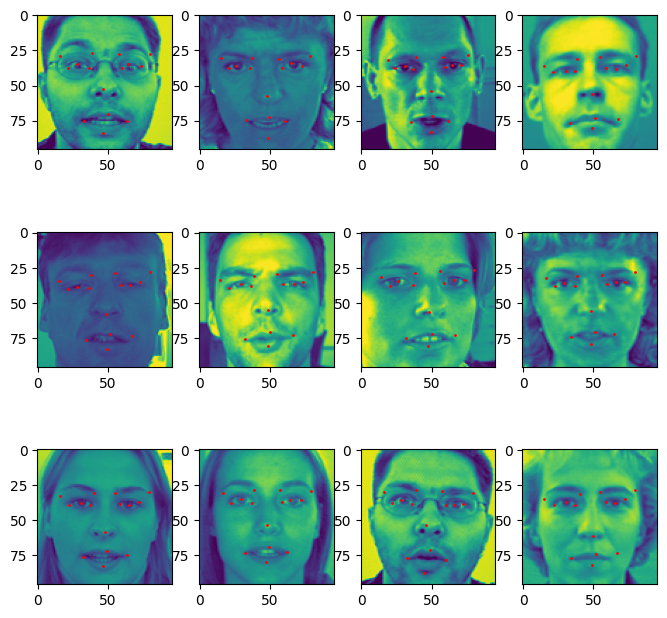

In [15]:
print_predicted_keypoints(model, test_dataloader)

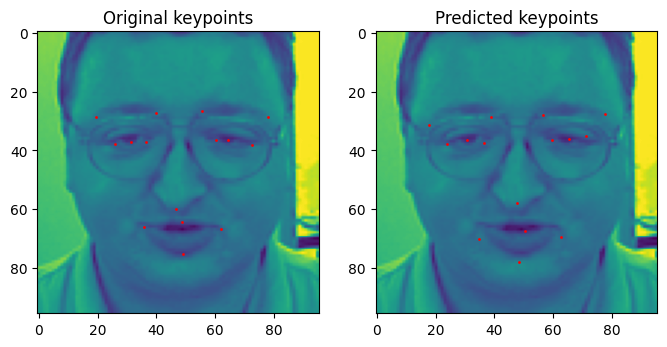

tensor(2.9270)

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 1

img, keypoints = train_dataset[50]
x = keypoints[0::2]
y = keypoints[1::2]

pred_keypoints = model(img.unsqueeze(dim=0).to(device)).squeeze().cpu().detach()

img = img.permute(1, 2, 0)
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.title(label='Original keypoints')
plt.scatter(x, y, c="red", s=1)

x = pred_keypoints[0::2]
y = pred_keypoints[1::2]
fig.add_subplot(rows, columns, 2)
plt.imshow(img)
plt.title('Predicted keypoints')
plt.scatter(x, y, c="red", s=1)

plt.show()
criterion(keypoints, pred_keypoints)
